In [49]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split 
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from scipy.optimize import curve_fit
from datetime import datetime,time
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline
warnings.filterwarnings("ignore")

jointure entre les tables 

In [50]:
vols= pd.read_csv("./vols.csv")
aeroports= pd.read_csv("./aeroports.csv")
compagnies= pd.read_csv("./compagnies.csv")

origin_aeroports = aeroports.rename(columns={'CODE IATA':'AEROPORT DEPART','NOM': 'ORIGIN_AIRPORT',
                                        'LIEU':'ORIGIN_LIEU','PAYS':'ORIGIN_PAYS','LONGITUDE':'ORIGIN_LONGITUDE',
                                        'LATITUDE':'ORIGIN_LATITUDE','HAUTEUR':'ORIGIN_HAUTEUR',
                                        'PRIX RETARD PREMIERE 10 MINUTES':'ORIGIN_PRIX RETARD PREMIERE 10 MINUTES',
                                        'PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES':'ORIGIN_PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES'})
destination_aeroports = aeroports.rename(columns={'CODE IATA':'AEROPORT ARRIVEE','NOM': 'DESTINATION_AIRPORT',
                                         'LIEU':'DESTINATION_LIEU','PAYS':'DESTINATION_PAYS','LONGITUDE':'DESTINATION_LONGITUDE',
                                         'LATITUDE':'DESTINATION_LATITUDE','HAUTEUR':'DESTINATION_HAUTEUR',
                                         'PRIX RETARD PREMIERE 10 MINUTES':'DESTINATION_PRIX RETARD PREMIERE 10 MINUTES',
                                         'PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES':'DESTINATION_PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES'})
del origin_aeroports['index']
del destination_aeroports['index']
del compagnies['index']

vols = pd.merge(vols, origin_aeroports, how= 'left', left_on='AEROPORT DEPART', right_on='AEROPORT DEPART')
vols = pd.merge(vols, destination_aeroports, how= 'left', left_on='AEROPORT ARRIVEE', right_on='AEROPORT ARRIVEE')
vols = pd.merge(vols, compagnies,  how='left', left_on='COMPAGNIE AERIENNE', right_on='CODE')
del vols['CODE']


In [4]:
vols

,index,IDENTIFIANT,VOL,CODE AVION,AEROPORT DEPART,AEROPORT ARRIVEE,DEPART PROGRAMME,HEURE DE DEPART,RETART DE DEPART,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,...,ORIGIN_PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES,DESTINATION_AIRPORT,DESTINATION_LIEU,DESTINATION_PAYS,DESTINATION_LONGITUDE,DESTINATION_LATITUDE,DESTINATION_HAUTEUR,DESTINATION_PRIX RETARD PREMIERE 10 MINUTES,DESTINATION_PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES,COMPAGNIE
0,0,651373,2317,28fa5df4d7,TIA,DSS,1410,1411.0,1.0,20.0,...,586,Blaise Diagne International Airport,Dakar,SN,-17.073333,14.670000,290.0,5499,120,Ne Va Pas Partout Airlines
1,1,4153042,1755,4b31cd6358,MPM,BOH,1455,1449.0,-6.0,15.0,...,12,Bournemouth Airport,Bournemouth,GB,-1.842500,50.779999,38.0,3147,278,Corporate Overlord Airways
2,2,3617513,804,f3e0769c08,TRN,TNA,1540,1607.0,27.0,9.0,...,849,Yaoqiang Airport,Jinan,CN,117.216003,36.857201,76.0,2066,795,Neverland Airlines
3,3,1829601,263,2ba258e5c4,BRU,SXF,2226,2219.0,-7.0,14.0,...,48,Berlin-SchÃ¶nefeld Airport,Berlin,DE,13.522500,52.380001,157.0,2151,685,Try Hard Airlines
4,4,1250864,4511,11e7ffe99f,VCE,AAL,1730,1719.0,-11.0,14.0,...,434,Aalborg Airport,Aalborg,DK,9.849243,57.092759,10.0,8346,353,Morally Ambiguious Fligthts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3279285,2999995,782415,769,eb935c21e5,AGP,GOI,2216,2216.0,0.0,16.0,...,143,Dabolim Airport,Vasco da Gama,IN,73.831398,15.380800,150.0,8381,919,Ne Va Pas Partout Airlines
3279286,2999996,2046281,1233,208b41519d,DUR,MPM,1318,1316.0,-2.0,12.0,...,823,Maputo Airport,Maputo,MZ,32.572601,-25.920799,145.0,4778,12,Try Hard Airlines
3279287,2999997,1996895,323,770ec5ae7b,BOH,HAN,755,756.0,1.0,13.0,...,278,Noi Bai International Airport,Hanoi,VN,105.806999,21.221201,39.0,8379,693,Try Hard Airlines
3279288,2999998,5294861,3626,5babf41084,DXB,PMI,1648,1720.0,32.0,17.0,...,848,Palma De Mallorca Airport,Palma De Mallorca,ES,2.738810,39.551701,27.0,902,411,Bel Air


### Dealing with with Na values 

In [51]:
vols.isna().sum()

index                                                                0
IDENTIFIANT                                                          0
VOL                                                                  0
CODE AVION                                                           0
AEROPORT DEPART                                                      0
AEROPORT ARRIVEE                                                     0
DEPART PROGRAMME                                                     0
HEURE DE DEPART                                                  51414
RETART DE DEPART                                                 51414
TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE                        53406
DECOLLAGE                                                        53406
TEMPS PROGRAMME                                                      6
TEMPS PASSE                                                      62529
TEMPS DE VOL                                                     62529
DISTAN

In [52]:
# drop column big amount NA values
vols = vols[vols.columns.difference(["RAISON D'ANNULATION", 'RETARD SYSTEM', 'RETARD SECURITE',
                                              'RETARD AVION', 'RETARD COMPAGNIE', 'RETARD METEO'])]

In [53]:
"""""""""""""""
print('Dataframe dimensions:', df.shape)
#____________________________________________________________
# gives some infos on columns types and number of null values

tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info
"""""""""""""""
vols.isna().sum()

AEROPORT ARRIVEE                                                    0
AEROPORT DEPART                                                     0
ANNULATION                                                          0
ARRIVEE PROGRAMMEE                                                  0
ATTERRISSAGE                                                    55336
CODE AVION                                                          0
COMPAGNIE                                                           0
COMPAGNIE AERIENNE                                             223233
DATE                                                                0
DECOLLAGE                                                       53406
DEPART PROGRAMME                                                    0
DESTINATION_AIRPORT                                                 0
DESTINATION_HAUTEUR                                                 0
DESTINATION_LATITUDE                                                0
DESTINATION_LIEU    

In [54]:
# drop NA values
vols = vols.dropna() #After dropping certian columns, we drop lines with NA values. There are just a few lines, not representative.

In [55]:
vols.isna().sum()

AEROPORT ARRIVEE                                               0
AEROPORT DEPART                                                0
ANNULATION                                                     0
ARRIVEE PROGRAMMEE                                             0
ATTERRISSAGE                                                   0
CODE AVION                                                     0
COMPAGNIE                                                      0
COMPAGNIE AERIENNE                                             0
DATE                                                           0
DECOLLAGE                                                      0
DEPART PROGRAMME                                               0
DESTINATION_AIRPORT                                            0
DESTINATION_HAUTEUR                                            0
DESTINATION_LATITUDE                                           0
DESTINATION_LIEU                                               0
DESTINATION_LONGITUDE    

In [56]:
len(vols)
print('There are %d flights in dataset' % len(vols))
vols.shape

There are 2997544 flights in dataset


(2997544, 42)

In [57]:
vols.head(5)

,AEROPORT ARRIVEE,AEROPORT DEPART,ANNULATION,ARRIVEE PROGRAMMEE,ATTERRISSAGE,CODE AVION,COMPAGNIE,COMPAGNIE AERIENNE,DATE,DECOLLAGE,...,ORIGIN_PRIX RETARD PREMIERE 10 MINUTES,RETARD A L'ARRIVEE,RETART DE DEPART,TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE,TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE,TEMPS DE VOL,TEMPS PASSE,TEMPS PROGRAMME,VOL,index
0,DSS,TIA,0,2059,2048.0,28fa5df4d7,Ne Va Pas Partout Airlines,NVPPA,10/4/2016,1431.0,...,4582,-1.0,1.0,10.0,20.0,197.0,227.0,229.0,2317,0
1,BOH,MPM,0,1925,1857.0,4b31cd6358,Corporate Overlord Airways,COA,16/7/2018,1504.0,...,4778,-25.0,-6.0,3.0,15.0,173.0,191.0,210.0,1755,1
3,SXF,BRU,0,2350,2323.0,2ba258e5c4,Try Hard Airlines,THA,9/1/2016,2233.0,...,5077,-22.0,-7.0,5.0,14.0,50.0,69.0,84.0,263,3
4,AAL,VCE,0,1841,1818.0,11e7ffe99f,Morally Ambiguious Fligthts,MAF,23/1/2016,1733.0,...,2143,-16.0,-11.0,7.0,14.0,45.0,66.0,71.0,4511,4
5,DXB,DUR,0,1317,1307.0,fe17bac29e,Corporate Overlord Airways,COA,14/4/2016,1010.0,...,5737,0.0,-7.0,10.0,22.0,237.0,269.0,262.0,1238,5


### cleaning

Spliter la date en JOUR/MOIS/ANNEE

In [58]:
# the date 
# Make a copy of the original data to avoid writing on the original data
df = vols.copy()

# following http://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
df['DateOfDeparture'] = pd.to_datetime(df['DATE'])
df['ANNEE'] = df['DateOfDeparture'].dt.year
df['MOIS'] = df['DateOfDeparture'].dt.month
df['JOUR'] = df['DateOfDeparture'].dt.day

Cnvertire les colonnes qui représente le temps en format HH:MM:SS

In [59]:
from datetime import datetime
#_____________________________________________________
# Function that convert the 'HHMM' string to datetime.time  
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________

In [60]:
df['DEPART PROGRAMME'] = df['DEPART PROGRAMME'].apply(format_heure)
df['HEURE DE DEPART'] = df['HEURE DE DEPART'].apply(format_heure)
df['ARRIVEE PROGRAMMEE'] = df['ARRIVEE PROGRAMMEE'].apply(format_heure)
df["HEURE D'ARRIVEE"] = df["HEURE D'ARRIVEE"].apply(format_heure)
##
#__________________________________________________________________________
df.loc[:5, ['DEPART PROGRAMME', 'ARRIVEE PROGRAMMEE', 'HEURE DE DEPART',
             "HEURE D'ARRIVEE", 'RETART DE DEPART', "RETARD A L'ARRIVEE"]]

,DEPART PROGRAMME,ARRIVEE PROGRAMMEE,HEURE DE DEPART,HEURE D'ARRIVEE,RETART DE DEPART,RETARD A L'ARRIVEE
0,14:10:00,20:59:00,14:11:00,20:58:00,1.0,-1.0
1,14:55:00,19:25:00,14:49:00,19:00:00,-6.0,-25.0
3,22:26:00,23:50:00,22:19:00,23:28:00,-7.0,-22.0
4,17:30:00,18:41:00,17:19:00,18:25:00,-11.0,-16.0
5,09:55:00,13:17:00,09:48:00,13:17:00,-7.0,0.0


In [15]:
#df.dtypes

### Descriptive Analysis / Exploratory Analysis

##### statistique des sur les compagnies aérienne

In [61]:
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['RETART DE DEPART'].groupby(df['COMPAGNIE AERIENNE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
COMPAGNIE AERIENNE,,,,
BTATA,-24.0,644.0,40139.0,9.181370
AP,-27.0,1433.0,51128.0,0.624804
AAPF,-46.0,996.0,64261.0,14.317160
APSLM,-35.0,836.0,78258.0,16.468259
FIPI,-82.0,963.0,119255.0,1.862580
OA,-26.0,1006.0,174731.0,11.860059
SMITH,-36.0,1278.0,186921.0,10.524452
THA,-24.0,1314.0,347795.0,14.929375
I6F,-55.0,1236.0,371833.0,8.955644


Pour bien illustrer le tableau ci dessus

In [62]:
abbr_companies = df.set_index('COMPAGNIE AERIENNE')['COMPAGNIE'].to_dict()

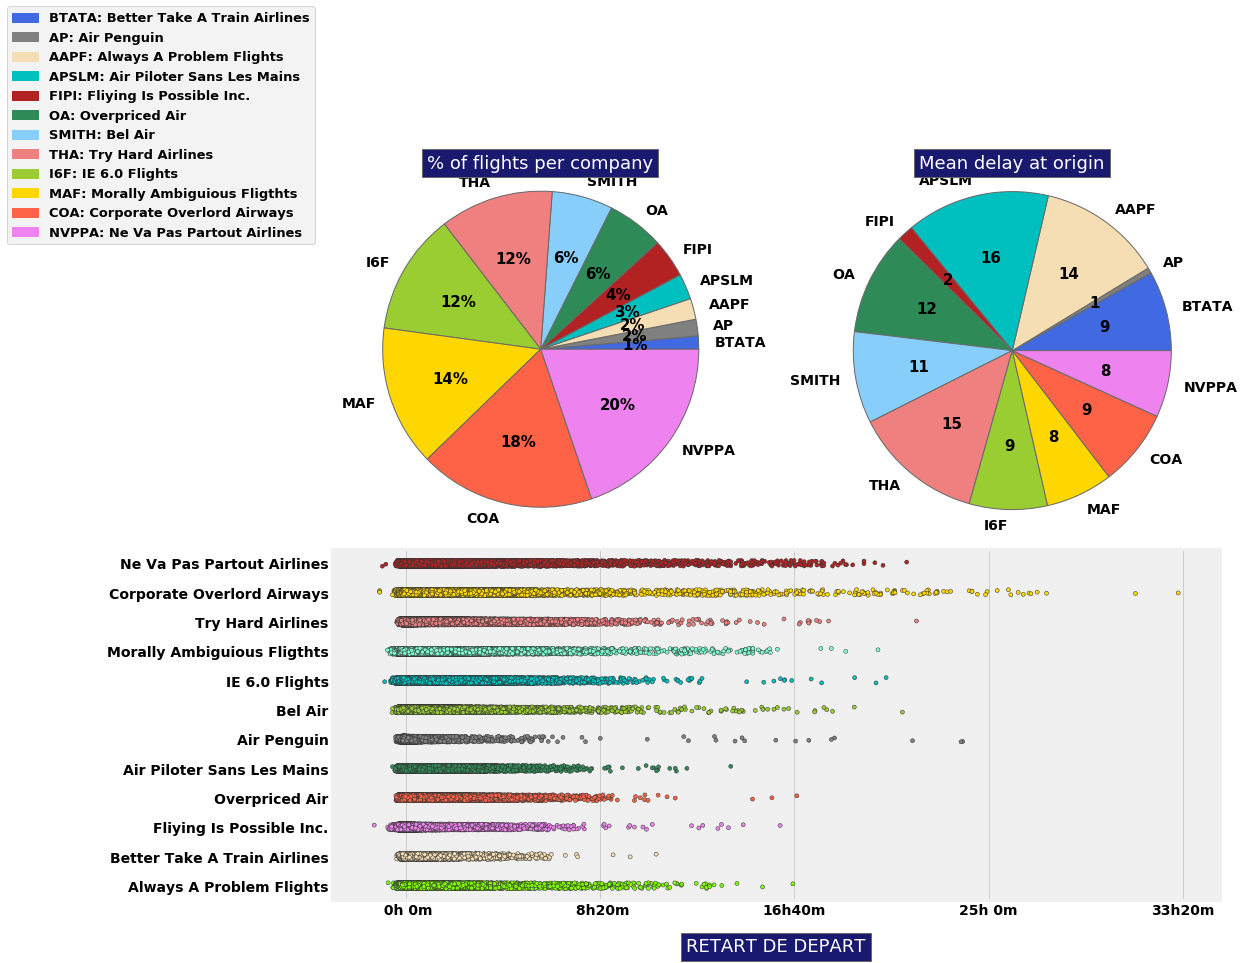

In [63]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['COMPAGNIE AERIENNE', 'RETART DE DEPART']]
df2['COMPAGNIE AERIENNE'] = df2['COMPAGNIE AERIENNE'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse','orange']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights # Airlines with most flights 
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue','orange']
# IL FAUT AVOIR LES MEME COULEUR POUR LES 2 GRAPHS
#___________________________________________________________________
ax3 = sns.stripplot(y="COMPAGNIE AERIENNE", x="RETART DE DEPART", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('RETART DE DEPART', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 


In [64]:
abbr_companies

{'NVPPA': 'Ne Va Pas Partout Airlines',
 'COA': 'Corporate Overlord Airways',
 'THA': 'Try Hard Airlines',
 'MAF': 'Morally Ambiguious Fligthts',
 'I6F': 'IE 6.0 Flights',
 'SMITH': 'Bel Air',
 'AP': 'Air Penguin',
 'APSLM': 'Air Piloter Sans Les Mains',
 'OA': 'Overpriced Air',
 'FIPI': 'Fliying Is Possible Inc.',
 'BTATA': 'Better Take A Train Airlines',
 'AAPF': 'Always A Problem Flights'}

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


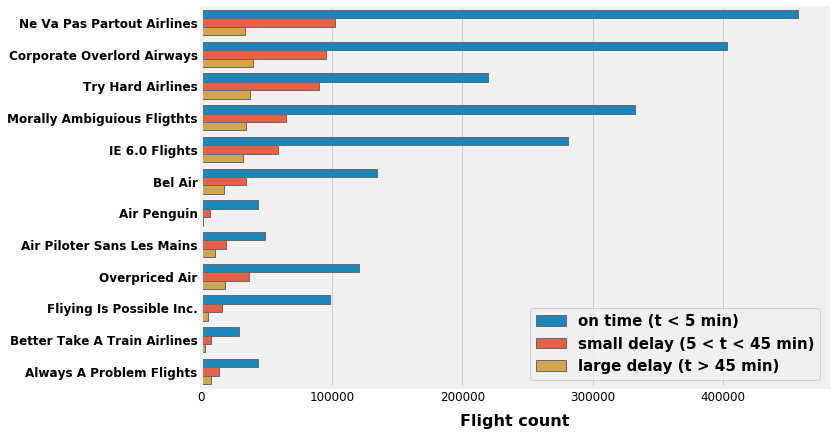

In [65]:
#___________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['RETART DE DEPART'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="COMPAGNIE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = df["COMPAGNIE"].unique()
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

### Retard : à l'arrivée ou du départ ?

In [66]:
df["COMPAGNIE"].unique()

array(['Ne Va Pas Partout Airlines', 'Corporate Overlord Airways',
       'Try Hard Airlines', 'Morally Ambiguious Fligthts',
       'IE 6.0 Flights', 'Bel Air', 'Air Penguin',
       'Air Piloter Sans Les Mains', 'Overpriced Air',
       'Fliying Is Possible Inc.', 'Better Take A Train Airlines',
       'Always A Problem Flights'], dtype=object)

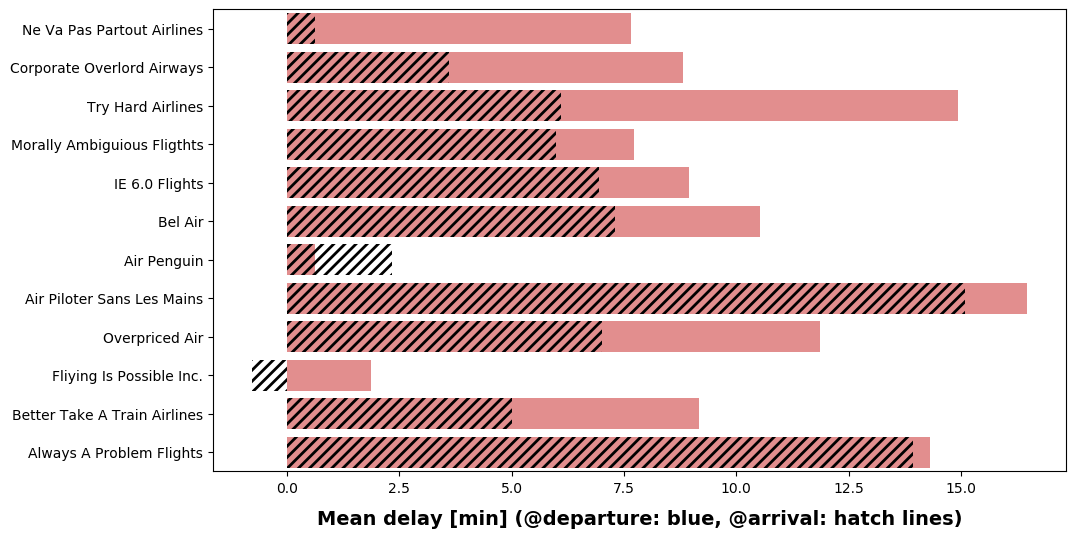

In [67]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="RETART DE DEPART", y="COMPAGNIE", data=df, color="lightcoral", ci=None)
ax = sns.barplot(x="RETARD A L'ARRIVEE", y="COMPAGNIE", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = df["COMPAGNIE"].unique()
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

### le nombre d'aéroports de destination/visités pour chaque compagnie aérienne ?

In [68]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['COMPAGNIE AERIENNE'] == carrier]['AEROPORT DEPART'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

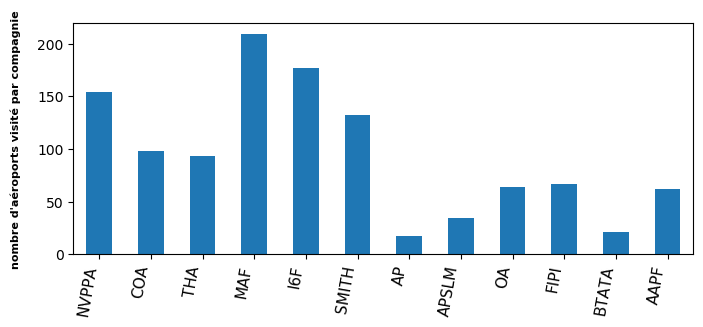

In [69]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = df['COMPAGNIE AERIENNE'].unique()
ax.set_xticklabels(labels)
plt.ylabel("nombre d'aéroports visité par compagnie", fontsize=8, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

### comment l'aéroport d'origine/depart impact les retards de depart?

In [24]:
airport_mean_delays = pd.DataFrame(pd.Series(df['AEROPORT DEPART'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

for carrier in abbr_companies.keys():
    df1 = df[df['COMPAGNIE'] == carrier]
    test = df1['RETART DE DEPART'].groupby(df['AEROPORT DEPART']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'].values()

AttributeError: 'Index' object has no attribute 'remove_unused_levels'

#### Variation dans le temps des retards de depart 

### preprocessing data

#### delete same features 

In [71]:
X=df.copy()
del X['ANNULATION']
del X['CODE AVION']
del X['DESTINATION_HAUTEUR']
del X['DESTINATION_LATITUDE']
del X['DESTINATION_LIEU']
del X['DESTINATION_LONGITUDE']
del X['DESTINATION_PAYS']
del X['DETOURNEMENT']
del X['IDENTIFIANT']
del X['ORIGIN_HAUTEUR']
del X['ORIGIN_LATITUDE']
del X['ORIGIN_LIEU']
del X['ORIGIN_LONGITUDE']
del X['ORIGIN_PAYS']
del X["TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE"]
del X["TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE"]
del X['VOL']
del X['DateOfDeparture']
del X['index']
del X['DATE']
del X['COMPAGNIE']
del X['NIVEAU DE SECURITE']
del X['DECOLLAGE']
del X['ATTERRISSAGE']
del X['DESTINATION_AIRPORT']
del X['ORIGIN_AIRPORT']

In [72]:
df.columns
#df["ANNEE"].unique()

Index(['AEROPORT ARRIVEE', 'AEROPORT DEPART', 'ANNULATION',
       'ARRIVEE PROGRAMMEE', 'ATTERRISSAGE', 'CODE AVION', 'COMPAGNIE',
       'COMPAGNIE AERIENNE', 'DATE', 'DECOLLAGE', 'DEPART PROGRAMME',
       'DESTINATION_AIRPORT', 'DESTINATION_HAUTEUR', 'DESTINATION_LATITUDE',
       'DESTINATION_LIEU', 'DESTINATION_LONGITUDE', 'DESTINATION_PAYS',
       'DESTINATION_PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES',
       'DESTINATION_PRIX RETARD PREMIERE 10 MINUTES', 'DETOURNEMENT',
       'DISTANCE', 'HEURE D'ARRIVEE', 'HEURE DE DEPART', 'IDENTIFIANT',
       'NIVEAU DE SECURITE', 'ORIGIN_AIRPORT', 'ORIGIN_HAUTEUR',
       'ORIGIN_LATITUDE', 'ORIGIN_LIEU', 'ORIGIN_LONGITUDE', 'ORIGIN_PAYS',
       'ORIGIN_PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES',
       'ORIGIN_PRIX RETARD PREMIERE 10 MINUTES', 'RETARD A L'ARRIVEE',
       'RETART DE DEPART', 'TEMPS DE DEPLACEMENT A TERRE A L'ATTERRISSAGE',
       'TEMPS DE DEPLACEMENT A TERRE AU DECOLLAGE', 'TEMPS DE VOL',
       'TEMPS PA

In [73]:
X

,AEROPORT ARRIVEE,AEROPORT DEPART,ARRIVEE PROGRAMMEE,COMPAGNIE AERIENNE,DEPART PROGRAMME,DESTINATION_PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES,DESTINATION_PRIX RETARD PREMIERE 10 MINUTES,DISTANCE,HEURE D'ARRIVEE,HEURE DE DEPART,...,ORIGIN_PRIX RETARD PREMIERE 10 MINUTES,RETARD A L'ARRIVEE,RETART DE DEPART,TEMPS DE VOL,TEMPS PASSE,TEMPS PROGRAMME,ANNEE,MOIS,JOUR,DELAY_LEVEL
0,DSS,TIA,20:59:00,NVPPA,14:10:00,120,5499,1749,20:58:00,14:11:00,...,4582,-1.0,1.0,197.0,227.0,229.0,2016,10,4,0
1,BOH,MPM,19:25:00,COA,14:55:00,278,3147,1325,19:00:00,14:49:00,...,4778,-25.0,-6.0,173.0,191.0,210.0,2018,7,16,0
3,SXF,BRU,23:50:00,THA,22:26:00,685,2151,337,23:28:00,22:19:00,...,5077,-22.0,-7.0,50.0,69.0,84.0,2016,9,1,0
4,AAL,VCE,18:41:00,MAF,17:30:00,353,8346,252,18:25:00,17:19:00,...,2143,-16.0,-11.0,45.0,66.0,71.0,2016,1,23,0
5,DXB,DUR,13:17:00,COA,09:55:00,848,6386,1562,13:17:00,09:48:00,...,5737,0.0,-7.0,237.0,269.0,262.0,2016,4,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3279285,GOI,AGP,23:26:00,NVPPA,22:16:00,919,8381,669,23:16:00,22:16:00,...,771,-10.0,0.0,100.0,120.0,130.0,2018,3,30,0
3279286,MPM,DUR,16:47:00,THA,13:18:00,12,4778,1597,16:52:00,13:16:00,...,5737,5.0,-2.0,255.0,276.0,269.0,2016,2,12,0
3279287,HAN,BOH,10:20:00,THA,07:55:00,693,8379,1558,10:07:00,07:56:00,...,3147,-13.0,1.0,229.0,251.0,265.0,2018,10,2,0
3279288,PMI,DXB,18:39:00,SMITH,16:48:00,411,902,604,19:07:00,17:20:00,...,6386,28.0,32.0,87.0,107.0,111.0,2016,6,27,1


### Feature enginireeng or Feature selection

##### Selecting the columns that we will be working with

In [26]:
df = df[['COMPAGNIE AERIENNE', 'AEROPORT DEPART', 'AEROPORT ARRIVEE',
        'DEPART PROGRAMME', 'HEURE DE DEPART', 'RETART DE DEPART',
        'ARRIVEE PROGRAMMEE', "HEURE D'ARRIVEE", "RETARD A L'ARRIVEE",
        ' ', ' ', ' ',' ',' ']]
df[:5]

KeyError: "[' '] not in index"

##### dealing with catégorial features and numurical features

### Prédictions 

##### Model de Classification : si il ya eu retard ou pas 

In [74]:
X

,AEROPORT ARRIVEE,AEROPORT DEPART,ARRIVEE PROGRAMMEE,COMPAGNIE AERIENNE,DEPART PROGRAMME,DESTINATION_PRIS RETARD POUR CHAQUE MINUTE APRES 10 MINUTES,DESTINATION_PRIX RETARD PREMIERE 10 MINUTES,DISTANCE,HEURE D'ARRIVEE,HEURE DE DEPART,...,ORIGIN_PRIX RETARD PREMIERE 10 MINUTES,RETARD A L'ARRIVEE,RETART DE DEPART,TEMPS DE VOL,TEMPS PASSE,TEMPS PROGRAMME,ANNEE,MOIS,JOUR,DELAY_LEVEL
0,DSS,TIA,20:59:00,NVPPA,14:10:00,120,5499,1749,20:58:00,14:11:00,...,4582,-1.0,1.0,197.0,227.0,229.0,2016,10,4,0
1,BOH,MPM,19:25:00,COA,14:55:00,278,3147,1325,19:00:00,14:49:00,...,4778,-25.0,-6.0,173.0,191.0,210.0,2018,7,16,0
3,SXF,BRU,23:50:00,THA,22:26:00,685,2151,337,23:28:00,22:19:00,...,5077,-22.0,-7.0,50.0,69.0,84.0,2016,9,1,0
4,AAL,VCE,18:41:00,MAF,17:30:00,353,8346,252,18:25:00,17:19:00,...,2143,-16.0,-11.0,45.0,66.0,71.0,2016,1,23,0
5,DXB,DUR,13:17:00,COA,09:55:00,848,6386,1562,13:17:00,09:48:00,...,5737,0.0,-7.0,237.0,269.0,262.0,2016,4,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3279285,GOI,AGP,23:26:00,NVPPA,22:16:00,919,8381,669,23:16:00,22:16:00,...,771,-10.0,0.0,100.0,120.0,130.0,2018,3,30,0
3279286,MPM,DUR,16:47:00,THA,13:18:00,12,4778,1597,16:52:00,13:16:00,...,5737,5.0,-2.0,255.0,276.0,269.0,2016,2,12,0
3279287,HAN,BOH,10:20:00,THA,07:55:00,693,8379,1558,10:07:00,07:56:00,...,3147,-13.0,1.0,229.0,251.0,265.0,2018,10,2,0
3279288,PMI,DXB,18:39:00,SMITH,16:48:00,411,902,604,19:07:00,17:20:00,...,6386,28.0,32.0,87.0,107.0,111.0,2016,6,27,1


In [75]:
#Make copy to avoid changing original data 
#X=df.copy()
label_X=df.copy()

#### Preprocessing

In [76]:
from sklearn.preprocessing import LabelEncoder

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
X['AEROPORT ARRIVEE']= label_encoder.fit_transform(label_X['AEROPORT ARRIVEE'])
X['AEROPORT DEPART']=label_encoder.fit_transform(label_X['AEROPORT DEPART'])
X['COMPAGNIE AERIENNE']=label_encoder.fit_transform(label_X['COMPAGNIE AERIENNE'])

#### Encode Time Function

In [77]:
#df['DateOfDeparture'] = pd.to_datetime(df['DATE'])
X['H_ARRIVEE PROGRAMMEE'] = X['ARRIVEE PROGRAMMEE'].apply(lambda x:int(x.strftime("%H")))
X['M_ARRIVEE PROGRAMMEE'] = X['ARRIVEE PROGRAMMEE'].apply(lambda x:int(x.strftime("%M")))

X['H_DEPART PROGRAMME'] = X['DEPART PROGRAMME'].apply(lambda x:int(x.strftime("%H")))
X['M_DEPART PROGRAMME'] = X['DEPART PROGRAMME'].apply(lambda x:int(x.strftime("%M")))


In [78]:
del X["HEURE DE DEPART"]
del X["HEURE D'ARRIVEE"]
del X['DEPART PROGRAMME']
del X['ARRIVEE PROGRAMMEE']
del X ['TEMPS PASSE']
#del X ['CODE AVION']


#### Split data

In [82]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y1, test_size=0.2)

In [80]:
df.columns
del X["RETART DE DEPART"]
del X["RETARD A L'ARRIVEE"]
Y1=df["RETART DE DEPART"]
Y2=df["RETARD A L'ARRIVEE"]

##### Model pour le calcule du cout des retards:

In [84]:
#Fitting simple linear regression to the Training Set
from sklearn.linear_model import LinearRegression 
regressor = LinearRegression()
regressor.fit(xtrain, ytrain)

#Predicting the prices
pred = regressor.predict(xtest)



In [87]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

mae = metrics.mean_absolute_error(ytest, pred)
mse = metrics.mean_squared_error(ytest, pred)
rmse = np.sqrt(metrics.mean_squared_error(ytest, pred))
r2_square = metrics.r2_score(ytest, pred)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('R2 Square', r2_square)

MAE: 10.418818560226647
MSE: 718.8362245286061
RMSE: 26.811121284433558
R2 Square 0.5268813346639944


#### Random Forest

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

n_estimators = 10
max_depth = 10
max_features = 10

RFR = RandomForestRegressor(
    n_estimators=n_estimators, max_depth=max_depth, max_features=max_features
)


In [89]:
RFR.fit(xtrain, ytrain)
pred_RFR = RFR.predict(xtest)
pred_RFR
#

array([-4.16162914, -4.84859043, -1.70949639, ..., -0.93545217,
       -1.24393459, -4.35002379])

In [90]:
mae = metrics.mean_absolute_error(ytest, pred_RFR)
mse = metrics.mean_squared_error(ytest, pred_RFR)
rmse = np.sqrt(metrics.mean_squared_error(ytest, pred_RFR))
r2_square = metrics.r2_score(ytest, pred_RFR)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('R2 Square', r2_square)

MAE: 7.897642806207728
MSE: 575.0464282411041
RMSE: 23.98012569277117
R2 Square 0.6215199104440216


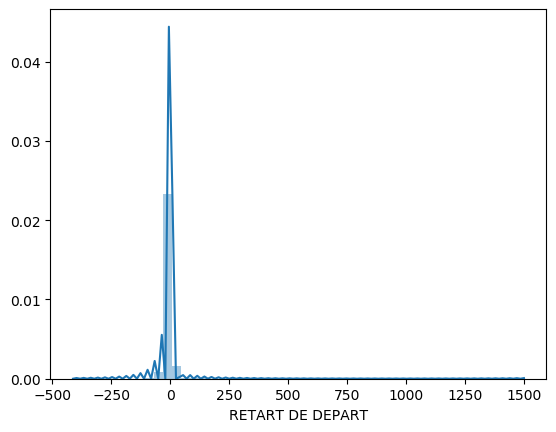

In [91]:
import seaborn as sns

sns.distplot((ytest - pred_RFR))



#### Xgboost

In [92]:
#from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import XGBRegressor
XGBR = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
XGBR.fit(xtrain, ytrain, verbose=False)

pred_XGBR = XGBR.predict(xtest)




In [93]:
mae = metrics.mean_absolute_error(ytest, pred_XGBR)
mse = metrics.mean_squared_error(ytest, pred_XGBR)
rmse = np.sqrt(metrics.mean_squared_error(ytest, pred_XGBR))
r2_square = metrics.r2_score(ytest, pred_XGBR)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)
print('R2 Square', r2_square)

MAE: 7.804617535212055
MSE: 566.0448686116555
RMSE: 23.791697472262367
R2 Square 0.6274444948382207
